In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

from torch import optim
import torch.nn.functional as F

In [2]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
class_map = {clss:id for id, clss in enumerate(classes)}
class_map

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [5]:
train_annot = pd.read_csv(r'annotations/cifar10_train_annotations.csv')
val_annot = pd.read_csv(r'annotations/cifar10_test_annotations.csv')

In [6]:
train_annot.head()

,Image_path,Label
0,airplane_1000.png,0
1,airplane_1001.png,0
2,airplane_1002.png,0
3,airplane_1003.png,0
4,airplane_1004.png,0


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
train_dataset = CustomImageDataset(
    annotations_file=r'annotations/cifar10_train_annotations.csv',
    img_dir=r'cifar10\cifar10\cifar10\train_',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [16]:
test_dataset = CustomImageDataset(
    annotations_file=r'annotations/cifar10_test_annotations.csv',
    img_dir=r'cifar10\cifar10\cifar10\test_',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.title(f"Label: {label}")
plt.imshow(img, cmap="gray")
plt.show()

In [20]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")

Feature batch shape: torch.Size([64, 3, 32, 32])


In [11]:


class CIFAR10_Net(nn.Module):
    def __init__(self):
        super(CIFAR10_Net, self).__init__()
        
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: [3, 32, 32], Output: [32, 32, 32]
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Output: [32, 16, 16]
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: [32, 16, 16], Output: [64, 16, 16]
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # Output: [64, 8, 8]
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: [64, 8, 8], Output: [128, 8, 8]
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # Output: [128, 4, 4]
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)  # Min dropout
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Input: [128 * 4 * 4], Output: [128]
        self.fc2 = nn.Linear(128, 64)  # Input: [128], Output: [64]
        self.fc3 = nn.Linear(64, 39)  # Output: [39] - number of classes
        
    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Forward pass through the second convolutional layer
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Forward pass through the third convolutional layer
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Apply dropout
        x = self.dropout(F.relu(self.fc1(x)))
        
        # Forward pass through the second fully connected layer
        x = F.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Instantiate the model
model = CIFAR10_Net()

model

CIFAR10_Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=39, bias=True)
)

In [23]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [33]:
batch_size = 64

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [28]:


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, criterion, optimizer)
    test_loop(test_loader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.556772  [   64/50000]
loss: 0.973128  [ 6464/50000]
loss: 0.905694  [12864/50000]
loss: 1.065870  [19264/50000]
loss: 0.905243  [25664/50000]
loss: 0.985386  [32064/50000]
loss: 0.915866  [38464/50000]
loss: 0.791021  [44864/50000]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.837562 

Epoch 2
-------------------------------
loss: 0.873087  [   64/50000]
loss: 0.687012  [ 6464/50000]
loss: 0.646670  [12864/50000]
loss: 0.644019  [19264/50000]
loss: 0.837653  [25664/50000]
loss: 0.911029  [32064/50000]
loss: 0.593522  [38464/50000]
loss: 0.665002  [44864/50000]
Test Error: 
 Accuracy: 74.4%, Avg loss: 0.734161 

Epoch 3
-------------------------------
loss: 0.673554  [   64/50000]
loss: 0.653921  [ 6464/50000]
loss: 0.477278  [12864/50000]
loss: 0.684119  [19264/50000]
loss: 0.551049  [25664/50000]
loss: 0.580684  [32064/50000]
loss: 0.612443  [38464/50000]
loss: 0.593540  [44864/50000]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.694344 

Epoc

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, f1_score
import numpy as np

def evaluate(net, test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.view_as(pred).numpy())
            all_outputs.extend(output.numpy())

    # Calculate metrics
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

    # Classification report and F1-Score
    all_preds = np.argmax(all_outputs, axis=1)
    print(classification_report(all_targets, all_preds))
    print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))

    # ROC Curve for each class
    targets_one_hot = label_binarize(all_targets, classes=np.arange(10))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], np.array(all_outputs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for Class: {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for each Category')
    plt.legend(loc="lower right")
    plt.show()





Test set: Average loss: 0.0237, Accuracy: 7771/10000 (78%)

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1000
           1       0.80      0.93      0.86      1000
           2       0.71      0.70      0.70      1000
           3       0.61      0.60      0.61      1000
           4       0.77      0.71      0.74      1000
           5       0.68      0.72      0.70      1000
           6       0.82      0.84      0.83      1000
           7       0.81      0.83      0.82      1000
           8       0.91      0.82      0.86      1000
           9       0.90      0.78      0.83      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

F1 Score: 0.7770563757569442


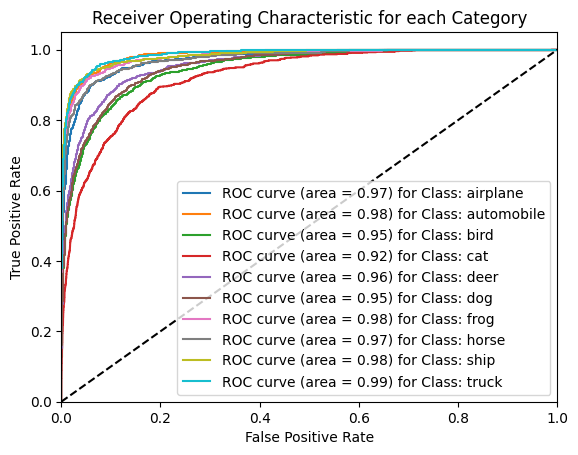

In [23]:
evaluate(model, test_loader)

In [24]:
print(f"Model structure: {model}\n\n")


Model structure: CIFAR10_Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=39

In [25]:

for name, param in model.named_parameters():
    print(f"Layer: {model} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: CIFAR10_Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=39, bias=Tru

In [31]:
path = r'cifar10\cifar10\cifar10\test_'

transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


for cls_ in classes:
    image_path = f'{path}\{cls_}_10010.png'
    X = read_image(image_path)

    X = transform(X)
    X = X.unsqueeze(0)
    # print(X.size())
    # break
    logits = model(X)
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    print(f"Actual Class: {cls_} | Predicted class:  {classes[y_pred.tolist()[0]]}")

Actual Class: airplane | Predicted class:  airplane
Actual Class: automobile | Predicted class:  automobile
Actual Class: bird | Predicted class:  bird
Actual Class: cat | Predicted class:  cat
Actual Class: deer | Predicted class:  deer
Actual Class: dog | Predicted class:  dog
Actual Class: frog | Predicted class:  frog
Actual Class: horse | Predicted class:  cat
Actual Class: ship | Predicted class:  ship
Actual Class: truck | Predicted class:  truck


In [158]:
torch.save(model, 'cifar10_model.pth')

In [32]:
model1 = torch.load('cifar10_model.pth')

C:\Users\user\AppData\Local\Temp\ipykernel_3988\2037099575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load('cifar10_model.pth')


In [33]:
path = r'cifar10\cifar10\cifar10\test_'

transform =transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


for cls_ in classes:
    image_path = f'{path}\{cls_}_10100.png'
    X = read_image(image_path)

    X = transform(X)
    X = X.unsqueeze(0)
    # print(X.size())
    # break
    logits = model1(X)
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    print(f"Actual Class: {cls_} | Predicted class:  {classes[y_pred.tolist()[0]]}")

Actual Class: airplane | Predicted class:  airplane
Actual Class: automobile | Predicted class:  automobile
Actual Class: bird | Predicted class:  bird
Actual Class: cat | Predicted class:  cat
Actual Class: deer | Predicted class:  deer
Actual Class: dog | Predicted class:  dog
Actual Class: frog | Predicted class:  frog
Actual Class: horse | Predicted class:  horse
Actual Class: ship | Predicted class:  ship
Actual Class: truck | Predicted class:  automobile
